In [52]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
import seaborn as sns
from sklearn import metrics
from sklearn.model_selection import train_test_split

%matplotlib inline 


In [53]:
sns.set(style="whitegrid", palette="muted", font_scale=1.5)
RANDOM_SEED = 42

from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [54]:
#from google.colab import files
#uploaded = files.upload()

In [56]:
#df = pd.read_csv(io.BytesIO(uploaded['dataset1.csv']))
df = pd.read_csv('dataset1.csv')

In [57]:
df = df.dropna()

df.head(5)

,Time_Stamp,Ax,Ay,Az,Gx,Gy,Gz,Mx,My,Mz,Activity_Label
0,1.364400e+12,-17.365944,19.517958,0.885323,-0.121868,2.177429,1.535715,18.300000,-44.160000,8.639999,Downstairs
1,1.364400e+12,-9.684067,13.933616,1.157730,-0.053145,-1.751656,1.254106,17.279999,-44.160000,9.179999,Downstairs
2,1.364400e+12,-4.045243,7.709117,-1.266692,-0.596510,-3.471853,1.176526,16.500000,-44.399998,9.360000,Downstairs
3,1.364400e+12,-1.770645,5.788648,-0.735499,-0.867734,-2.983771,0.893696,15.900000,-44.520000,9.360000,Downstairs
4,1.364400e+12,2.819412,3.963521,0.599295,-0.541227,-2.662762,0.328645,15.000000,-44.700000,9.240000,Downstairs


In [58]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 160655 entries, 0 to 160654
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   Time_Stamp      160655 non-null  float64
 1   Ax              160655 non-null  float64
 2   Ay              160655 non-null  float64
 3   Az              160655 non-null  float64
 4   Gx              160655 non-null  float64
 5   Gy              160655 non-null  float64
 6   Gz              160655 non-null  float64
 7   Mx              160655 non-null  float64
 8   My              160655 non-null  float64
 9   Mz              160655 non-null  float64
 10  Activity_Label  160655 non-null  object 
dtypes: float64(10), object(1)
memory usage: 14.7+ MB


In [59]:
activity_count = df['Activity_Label'].value_counts()
print(activity_count)

Walking       32001
Sitting       30000
Standing      30000
Running       28451
Upstairs      21750
Downstairs    18453
Name: Activity_Label, dtype: int64


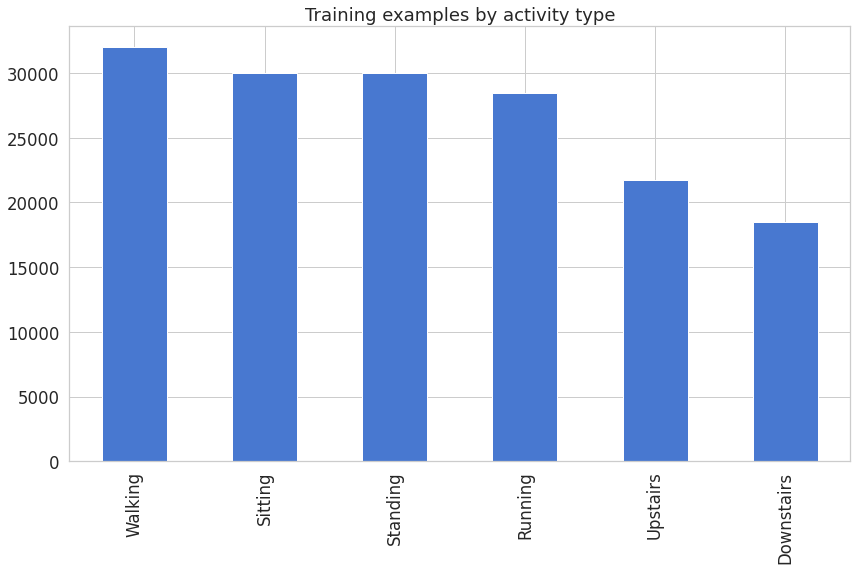

In [60]:
activity_count.plot(kind = 'bar', title ='Training examples by activity type', figsize=(14,8))

In [61]:
countofactivityperperson = df["Time_Stamp"].value_counts()
countofactivityperperson

1.364400e+12    66252
1.360000e+12    60000
1.364300e+12    19303
1.364390e+12    15100
Name: Time_Stamp, dtype: int64

In [62]:
totalactivity = countofactivityperperson.sum()
totalactivity

160655

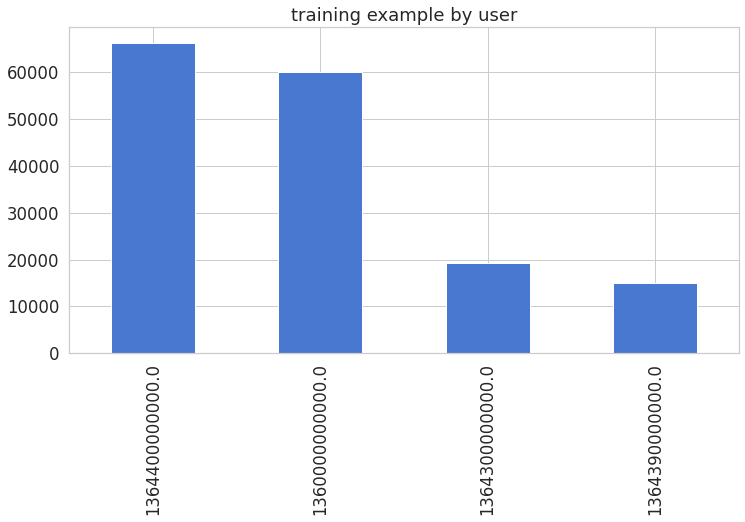

In [63]:
countofactivityperperson.plot(kind = 'bar', title = 'training example by user', figsize=(12,6))

In [64]:
def plot_activity(activity,df):
  extractrowsofactivity = (df['Activity_Label'] == activity)
  data = df[extractrowsofactivity]
  data = data[['Ax','Ay', 'Az']]
  data = data[:200]
  
  ax = data.plot(subplots = True, figsize=(16,12), title =activity)

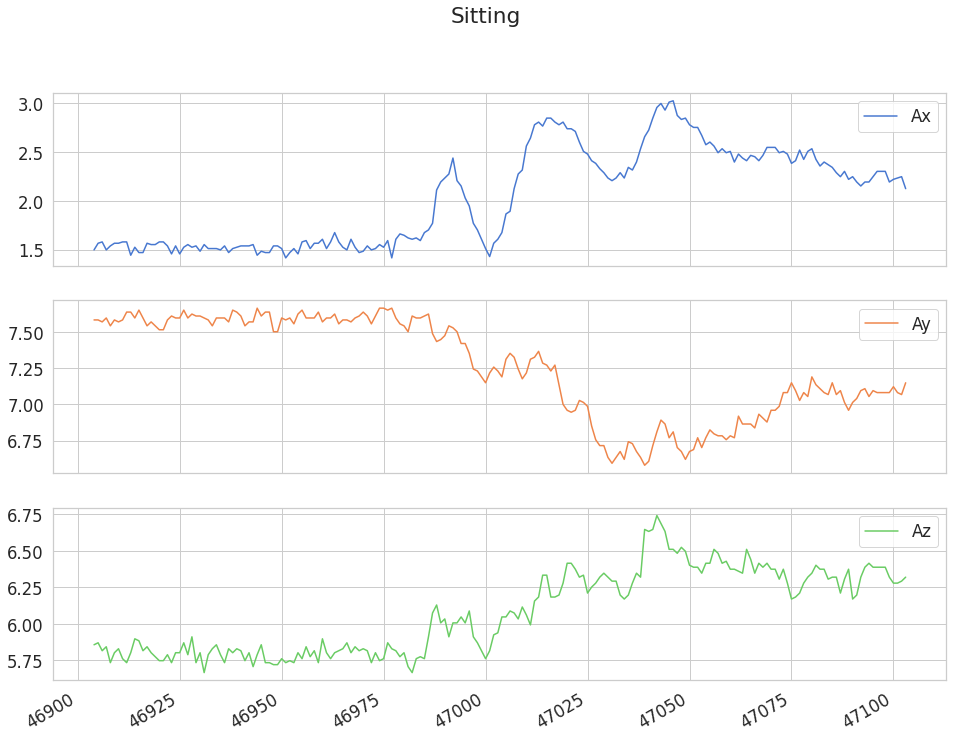

In [65]:
plot_activity('Sitting',df)

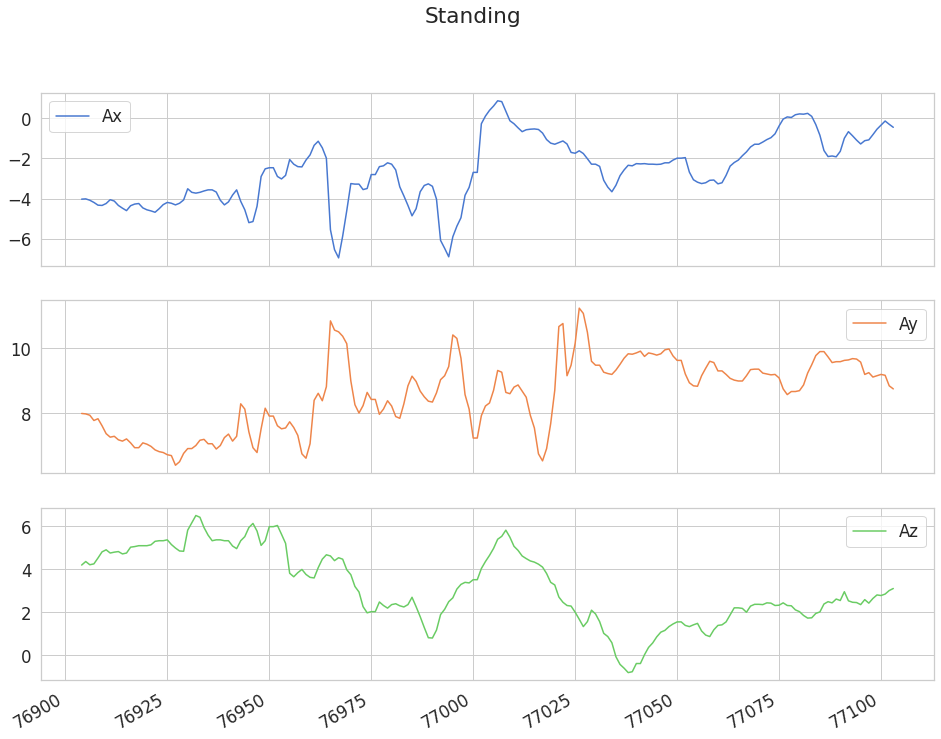

In [66]:
plot_activity('Standing',df)

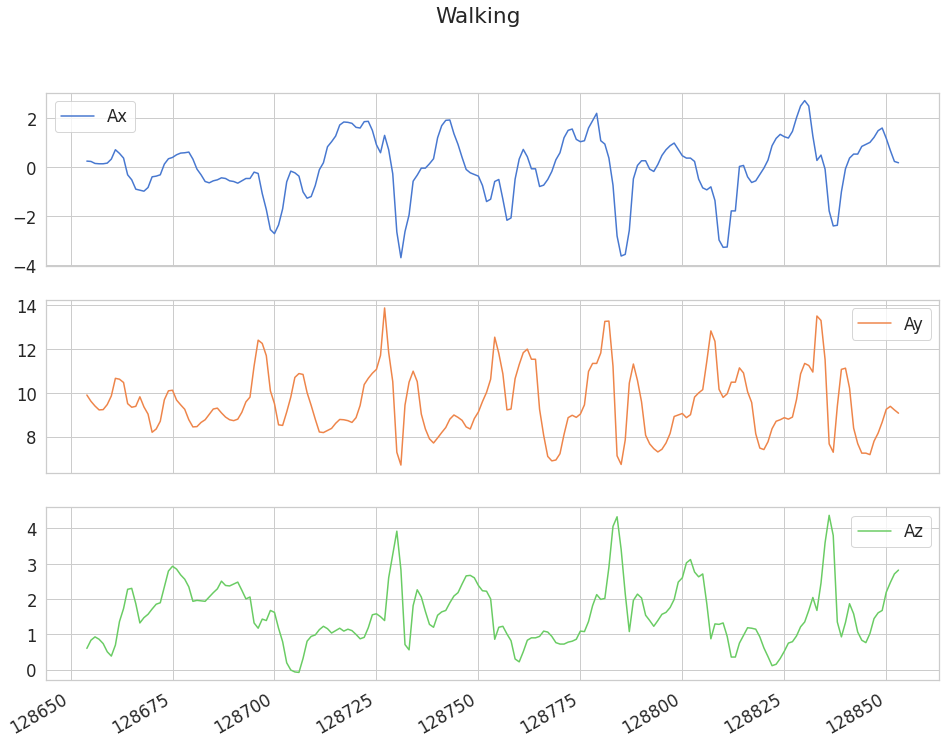

In [67]:
plot_activity('Walking',df)

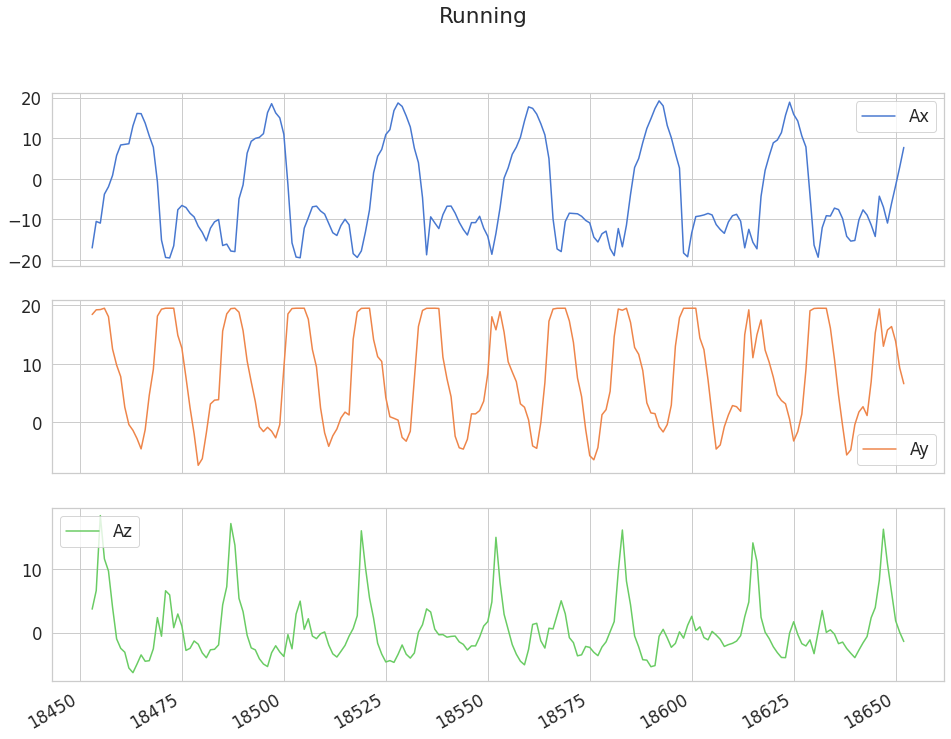

In [68]:
plot_activity('Running',df)

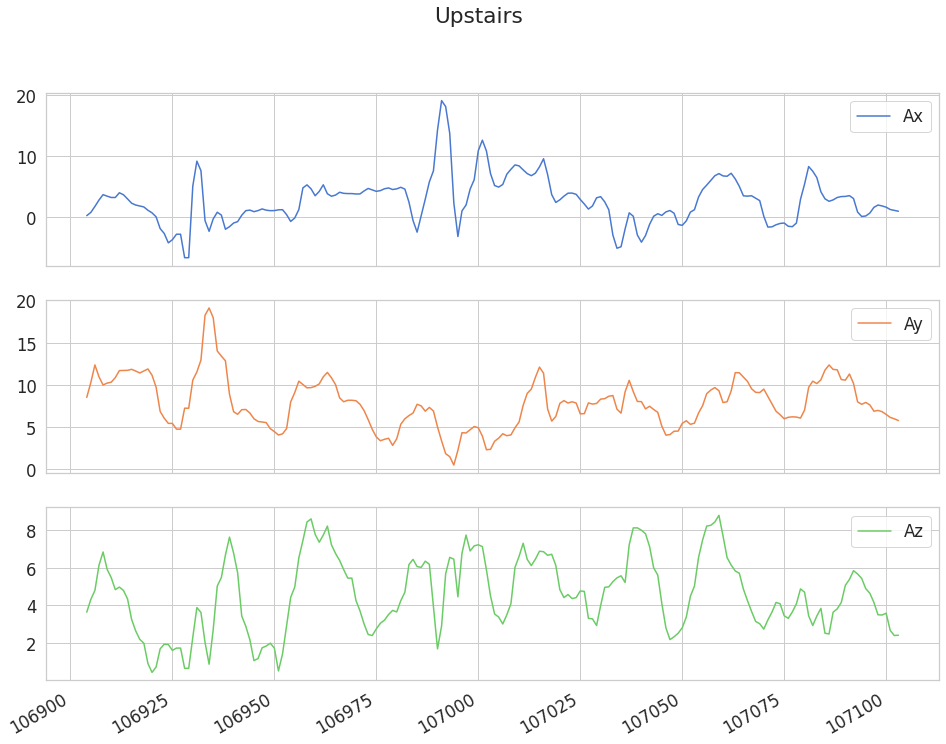

In [69]:
plot_activity('Upstairs',df)

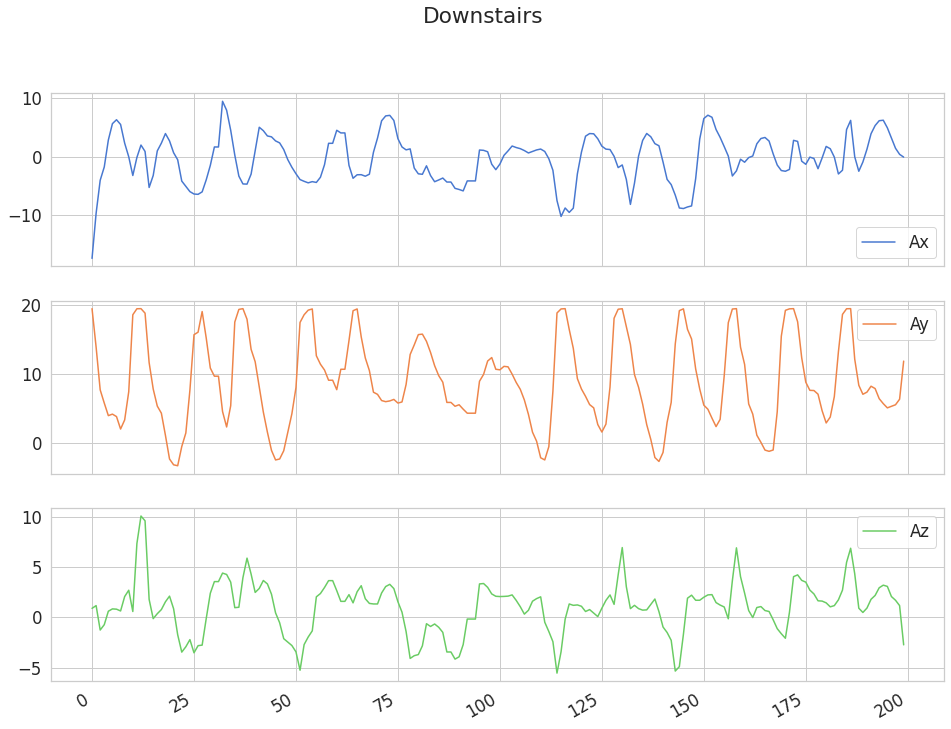

In [70]:
plot_activity('Downstairs',df)

In [71]:

# DATA PREPROCESSING
N_time_steps = 200
N_features = 3
step = 20
segments = []
labels = []
for i in range(0, len(df)-N_time_steps,step):
  xs= df['Ax'].values[i:i+N_time_steps]
  ys= df['Ay'].values[i:i+N_time_steps]
  zs= df['Az'].values[i:i+N_time_steps]
  label = stats.mode(df['Activity_Label'][i:i+N_time_steps])
  label = label[0][0]
  segments.append([xs,ys,zs])
  labels.append(label)



In [72]:
np.array(segments).shape

(8023, 3, 200)

In [73]:
#transforming shape
reshaped_segments = np.asarray(segments, dtype = np.float32).reshape(-1 , N_time_steps, N_features)
reshaped_segments.shape

(8023, 200, 3)

In [74]:
labels = np.asarray(pd.get_dummies(labels), dtype = np.float32)

In [75]:
print(labels)

[[1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 ...
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1.]]


In [76]:
print(labels.shape)

(8023, 6)


In [77]:
X_train, X_test, Y_train, Y_test = train_test_split(reshaped_segments, labels, test_size = 0.2, random_state = RANDOM_SEED)

In [78]:
len(X_train)

6418

In [79]:
len(X_test)

1605

In [80]:
N_classes = 6
N_hidden_units = 64

In [89]:
def create_LSTM_model(inputs):
  W = {
       'hidden' : tf.Variable(tf.random.normal([N_features, N_hidden_units])),
       'output' : tf.Variable(tf.random.normal([N_hidden_units,N_classes]))
  }
  biases = {
      'hidden' : tf.Variable(tf.random.normal([N_hidden_units], mean = 0.1)),
      'output' : tf.Variable(tf.random.normal([N_classes]))      
  }
  X = tf.transpose(inputs , [1,0,2])
  X = tf.reshape(X , [-1 , N_features])
  hidden = tf.nn.relu(tf.matmul(X, W['hidden']) + biases['hidden'])
  hidden = tf.split(hidden , N_time_steps, 0)
  
  lstm_layers = [tf.contrib.rnn.BasicLSTMCell(N_hidden_units, forget_bias = 1.0) for _ in range (2)]
  lstm_layers = tf.contrib.rnn.MultiRNNCell(lstm_layers)

  outputs , _ = tf.contrib.rnn.static_rnn(lstm_layers, hidden, dtype = tf.float32)

  lstm_last_output = outputs[-1]
  return tf.matmul(lstm_last_output, W['output']) + biases['output']



In [90]:
from tensorflow.python.framework import ops
ops.reset_default_graph()

In [93]:
#import tensorflow.compat.v1 as tf1
#tf.disable_v2_behavior()
X = tf.compat.v1.placeholder(tf.float32, [None, N_time_steps, N_features], name = 'input')
Y = tf.compat.v1.placeholder(tf.float32, [None, N_classes])

In [ ]:
#import tensorflow as tf
pred_y = create_LSTM_model(X)
pred_softmax = tf.nn.softmax(pred_y, name = 'y_')

In [ ]:
L2_LOSS = 0.0015
l2 = L2_LOSS * \
  sum(tf.nn.l2_loss(tf_var) for tf_var in tf.trainable_variables())
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = pred_y, labels = Y)) + l2


In [ ]:
Learning_rate = 0.0025
optimizer = tf.train.AdamOptimizer(learning_rate = Learning_rate).minimize(loss)
correct_pred = tf.equal(tf.argmax(pred_softmax , 1), tf.argmax(Y,1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, dtype = tf.float32))

In [ ]:
N_epochs = 50
batch_size = 1024


In [ ]:
saver = tf.train.Saver()
history = dict (train_loss = [], train_acc = [], test_loss = [], test_acc = [])
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())
train_count = len(X_train)

for i in range (1, N_epochs+1):
  for start, end in zip(range(0,train_count, batch_size), range(batch_size,train_count+1, batch_size)):
    sess.run(optimizer,feed_dict={X: X_train[start:end], 
                                  Y: Y_train[start:end]})
  _,acc_train, loss_train = sess.run([pred_softmax,accuracy,loss], feed_dict={
      X:X_train, Y:Y_train})
  _,acc_test,loss_test = sess.run([pred_softmax,accuracy,loss], feed_dict={
      X:X_test, Y:Y_test})
  history['train_loss'].append(loss_train)
  history['train_acc'].append(acc_train)
  history['test_loss'].append(loss_test)  
  history['test_acc'].append(acc_test)
  
  if (i != 1 and i % 10 != 0):
    print(f'epoch: {i} test_accuracy:{acc_test} loss:{loss_test}')
predictions, acc_final, loss_final = sess.run([pred_softmax, accuracy, loss], feed_dict = { X:X_test, Y:Y_test})
print()
print(f'final results : accuracy : {acc_final} loss : {loss_final}')
    

epoch: 2 test_accuracy:0.6971962451934814 loss:1.4320471286773682
epoch: 3 test_accuracy:0.8006230592727661 loss:1.255730390548706
epoch: 4 test_accuracy:0.8467289805412292 loss:1.1295710802078247
epoch: 5 test_accuracy:0.8822429776191711 loss:1.0519989728927612
epoch: 6 test_accuracy:0.8809968829154968 loss:1.006063461303711
epoch: 7 test_accuracy:0.8785046935081482 loss:1.0059698820114136
epoch: 8 test_accuracy:0.9040498733520508 loss:0.9541240930557251
epoch: 9 test_accuracy:0.9127725958824158 loss:0.9249656200408936
epoch: 11 test_accuracy:0.9202492237091064 loss:0.8723455667495728
epoch: 12 test_accuracy:0.9345794320106506 loss:0.8389042615890503
epoch: 13 test_accuracy:0.9283488988876343 loss:0.8365824222564697
epoch: 14 test_accuracy:0.9289719462394714 loss:0.8442765474319458
epoch: 15 test_accuracy:0.9376947283744812 loss:0.825635552406311
epoch: 16 test_accuracy:0.9308411478996277 loss:0.8527410626411438
epoch: 17 test_accuracy:0.940809965133667 loss:0.7720271348953247
epoch: 

In [ ]:
#pickle.dump(predictions, open("predictions.p", "wb"))
#pickle.dump(history, open("history.p", "wb"))
#tf.train.write_graph(sess.graph_def, '.', './checkpoint/har.pbtxt')
#saver.save(sess, save_path = "./checkpoint/har.ckpt")
#sess.close()

In [ ]:
plt.figure(figsize=(12,8))

plt.plot(np.array(history['train_loss']), "r--", label="Train loss")
plt.plot(np.array(history['train_acc']), "g--", label="Train accuracy")

plt.plot(np.array(history['test_loss']), "r--", label="Test loss")
plt.plot(np.array(history['test_acc']), "g--", label="Test accuracy")

plt.title("Training session's progress over iteration")
plt.legend(loc = 'upper right', shadow = True)
plt.ylabel('Training Progress(Loss or Accuracy values)')
plt.xlabel('Training Epoch')
plt.ylim(0)

plt.show()

In [ ]:
LABELS = ['Walking', 'Sitting', 'Standing', 'Running', 'Upstairs', 'Downstairs']

In [ ]:
max_test = np.argmax(Y_test, axis=1)
max_predictions = np.argmax(predictions, axis = 1)
confusion_matrix = metrics.confusion_matrix(max_test, max_predictions)

plt.figure(figsize=(16,14))
sns.heatmap(confusion_matrix, xticklabels = LABELS, yticklabels = LABELS, annot =True, fmt = "d")
plt.title("Confusion Matrix")
plt.xlabel('Predicted_label')
plt.ylabel('True Label')
plt.show()